In [1]:
import numpy as np
from copy import deepcopy
from astropy.time import Time
import astropy.io.ascii as asci
import astropy.constants as const

In [2]:
import matplotlib
import matplotlib.pyplot as plt
fs= 10
matplotlib.rcParams['font.size']=fs
ms = 6
matplotlib.rcParams['lines.markersize']=ms

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)


In [3]:
z = 0.018
tmax = 59321  

D_pc = cosmo.luminosity_distance([z])[0].value * 1e+6 
D_10kpc = D_pc / (1e+4)
D_cm = D_pc * const.pc.cgs.value

In [4]:
def add_xray_lc(ax = None, ax1 = None):
    ##### ADD XRT light curve
    df = asci.read("../data/xrt/swift_summary.dat")
    t = (df["mjd"].data - tmax) / (1+z)
    
    fl = df["fl"].data 
    efl = df["fl_unc"].data 
    
    D = cosmo.luminosity_distance([z])[0].value * 1e+6 # in pc
    D_cm = D * const.pc.cgs.value
    multi = 4 * np.pi * D_cm**2
    
    L = fl*multi
    eL = efl*multi
    
    lgL = np.log10(L)
    lgL_unc = 1 / np.log(10) * eL / L
    
    if ax is not None:
        color_det = "k"
        
        ms_det = 3
        zorder = 10
        
        ix = df["cr_unc"]==0
        ix1 = ~ix&(t<270)
        ix2 = ~ix&(t>=270)
        lgL_unc[ix] = 0
        ax.errorbar(t[ix1], lgL[ix1], yerr=lgL_unc[ix1],
                    fmt = "s:", color = color_det, elinewidth = 1, 
                    markersize = ms_det, zorder=zorder, linewidth = 0.8,
                    label = "XRT "+r"$L_{\rm X}$")
        ax.errorbar(t[ix2], lgL[ix2], yerr=lgL_unc[ix2],
                    fmt = "s:", color = color_det, elinewidth = 1, 
                    markersize = ms_det, zorder=zorder, linewidth = 0.8)
        for i in range(len(ix)):
            if ix[i] == True:
                ax.arrow(t[i], lgL[i], 0, -0.06, color = color_det , alpha = 0.7,
                          head_width = 4, width = 1.2, head_length = 0.05)
                
        #ax.plot(t, lgL, linestyle = ":", color = color_det,
        #        zorder=zorder, linewidth = 1)
    
    xlist = {}
    xlist["x1"] = t
    xlist["y1"] = lgL
    xlist["ey1"] = lgL_unc
    
    if ax1 is not None:
        color1 = "dimgrey"
        color2 = "darkgrey"
        ax1.errorbar(t[~ix], df["alpha_OX"][~ix], df["alpha_OX_unc"][~ix], label = r"$\alpha_{\rm OX}$",
                     fmt = "P", color = color1, markersize = 3, elinewidth = 0.8)
        ax1.errorbar(t[~ix], df["alpha_OSX"][~ix], df["alpha_OSX_unc"][~ix], label = r"$\alpha_{\rm OSX}$",
                     fmt = "X", color = color2, markersize = 3, elinewidth = 0.8)
        ax1.legend(loc = "upper left", fontsize = fs-0.5,
                      borderpad=0.2, labelspacing = 0.2, handlelength = 1.5,
                      handleheight=0.5, handletextpad = 0.2, borderaxespad=0.2,
                      columnspacing=1)
        for i in range(len(ix)):
            if ix[i] == True:
                ax1.arrow(t[i], df["alpha_OX"][i], 0, -0.06, color = color1, alpha = 0.7,
                          head_width = 4, width = 1.2, head_length = 0.05)
                ax1.arrow(t[i], df["alpha_OSX"][i], 0, -0.06, color = color2, alpha = 0.7,
                          head_width = 4, width = 1.2, head_length = 0.05)
        
    ##### ADD NICER light curve
    color_det = "darkgoldenrod"
    zorder = 2
    ms_det = 2
    
    sum_name = "/Users/yuhanyao/Dropbox/Projects/AT2021ehb/nicer/tables/Xray_pars_ni_obsid.dat"
    tb2 = asci.read(sum_name)
    colnames = tb2.colnames
    for i in range(len(colnames)):
        colname = colnames[i]
        if len(colname) > 6:
            if colname[-6:] == "_fixNh":
                #print (colname)
                if colname[:-6] in colnames:
                    print ("remove", colname[:-6])
                    tb2.remove_column(colname[:-6])
                #print ("raname", colname, "to", colname[:-6])
                tb2.rename_column(colname, colname[:-6])
    tb2["nH"] = 9.97
    tb2["nH_left"] = 0
    tb2["nH_right"] = 0
    #ix2 = tb2["mjd"]>= max(tb1["mjd"])
    tb = tb2#[ix2]
    
    fl, fl_left, fl_right = tb["fl"].data, tb["fl_left"].data, tb["fl_right"].data
    L = fl*multi
    L_left = fl_left*multi
    L_right = fl_right*multi
    
    lgL = np.log10(L)
    lgL_left = 1 / np.log(10) * L_left / L
    lgL_right = 1 / np.log(10) * L_right / L
    
    x = tb["x"].data
    if ax is not None:
        ax.errorbar(x, lgL, yerr=[lgL_left, lgL_right],
                    fmt = "o-", color = color_det, elinewidth = 1, 
                    markersize = ms_det, zorder=zorder, linewidth = 0.8,
                    label = r"$NICER\; L_{\rm X}$")
    
    xlist["x3"] = x
    xlist["y3"] = lgL
    xlist["ey3"] = (lgL_left + lgL_right)/2
    
    x = np.hstack([xlist["x1"], xlist["x3"]])
    y = np.hstack([xlist["y1"], xlist["y3"]])
    ind = np.argsort(x)
    x = x[ind]
    y = y[ind]
    xlist["x"] = x
    xlist["y"] = y
    return xlist

In [5]:
def custom_myax1(axs):
    xmin = -60
    xmax = (Time("2022-04-06T00:00:00").mjd-tmax)/(1+z)
    
    majorx = 50
    minorx = 10
    for i in range(2):
        axs[i].tick_params(which = 'major', length = 4, top=True, direction = "in", 
                   right = True)
        axs[i].tick_params(which = 'minor', length = 2, top=True, direction = "in", 
                   right = True)
        axs[i].xaxis.set_major_locator(plt.MultipleLocator(majorx))
        axs[i].xaxis.set_minor_locator(plt.MultipleLocator(minorx))
    
    # luminosity
    ymax = 44.2
    ymin = 40.4
    axs[0].yaxis.set_major_locator(plt.MultipleLocator(1))
    axs[0].yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    axs[0].set_ylabel("log"+r"$L$"+" ("+r"$\rm erg\,s^{-1}$"+")")
    add_background(axs[0], ymin, ymax, add_label=True)
    axs[0].set_ylim(ymin, ymax)
    
    ########## right y axis ##########
    ########## from L to L_Edd
    L_Edd = 1.26e+38 * 10**(7.0312) # in erg/s
    axL = axs[0].twinx()
    axL.tick_params(which = 'major', length = 4, direction = "in")
    axL.tick_params(which = 'minor', length = 2, direction = "in")
    add_offset = -1 * np.log10(L_Edd) 
    ymin0_ = add_offset + ymin
    ymax0_ = add_offset + ymax
    ylims0_ = (ymin0_, ymax0_)
    yticks2_label = create_new_yticks_lum(ylims0_, which = "major")
    yticks2_real = []
    for x in yticks2_label:
        yticks2_real.append(x - add_offset)
    yticks2_real = np.array(yticks2_real)
    
    yticks2_label_minor = create_new_yticks_lum(ylims0_, which = "minor")
    yticks2_real_minor = []
    for x in yticks2_label_minor:
        yticks2_real_minor.append(x - add_offset)
    yticks2_real_minor = np.array(yticks2_real_minor)
   
    axL.set_yticks(yticks2_real, minor = False)
    axL.set_yticks(yticks2_real_minor, minor = True)
    axL.set_ylim(ymin, ymax)
    axL.set_yticklabels(yticks2_label)
    axL.set_ylabel("log("+r"$L_/L_{\rm Edd}$"+")")
    
    # alpha_OX
    ymax1 = -0.55
    ymin1 = -2.65
    axs[1].yaxis.set_major_locator(plt.MultipleLocator(0.5))
    axs[1].yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    # add Galactic nH value from HI4PI+2016
    add_background(axs[1], ymin1, ymax1)
    axs[1].set_ylim(ymin1, ymax1)
    axs[1].set_ylabel(r"$\alpha_{\rm OX}$"+" or "+r"$\alpha_{\rm OSX}$")
    
    axs[1].set_xlim(xmin, xmax)
    axs[1].set_xlabel("Rest-frame days since MJD 59321")
    
    axs[0].legend(loc = "center left", fontsize = fs-0.5,
                  borderpad=0.2, labelspacing = 0.2, handlelength = 1.5,
                  handleheight=0.5, handletextpad = 0.2, borderaxespad=0.2,
                  columnspacing=1, bbox_to_anchor = (0, 0.3))

In [6]:
def add_UVoptical(axs = None, doRT = False):
    filename = "../data/opt_lc/bbpars_ebv_0.00.dat"
    tb = asci.read(filename)
    phase = tb["phase"].data
    Lbb = tb["L"].data
    Lbb_unc = tb["eL"].data
    Tbb = tb["T"].data
    Tbb_unc = tb["eT"].data
    Rbb = tb["R"].data
    Rbb_unc = tb["eR"].data
    
    lgLbb = np.log10(Lbb)
    lgLbb_unc = 1 / np.log(10) * Lbb_unc / Lbb
    
    lgTbb = np.log10(Tbb)
    lgTbb_unc = 1 / np.log(10) * Tbb_unc / Tbb
    
    lgRbb = np.log10(Rbb)
    lgRbb_unc = 1 / np.log(10) * Rbb_unc / Rbb
    
    if axs is not None:
        ms_det = 5
        color_det = "forestgreen"
        marker = "*"
        zorder = 5
        lw = 0.5
        axs[0].errorbar(phase, lgLbb, lgLbb_unc, color = color_det, marker = marker, 
                    markersize = ms_det, linestyle = "none", zorder = zorder, linewidth = lw)
        
        axs[0].errorbar([0,0], [40,40], [0.5,0.5], color = color_det, marker = marker, 
                    markersize = ms_det, linestyle = "--", zorder = zorder, linewidth = lw,
                    label = "UV/optical "+r"$L_{\rm bb}$")
        
    if doRT:
        ########## right y axis ##########
        ########## from K to eV
        axT = axs[2].twinx()
        axT.tick_params(which = 'major', length = 4, direction = "in")
        axT.tick_params(which = 'minor', length = 2, direction = "in")
        axT.errorbar(phase, lgTbb, lgTbb_unc, color = color_det, marker = marker, 
                    markersize = ms_det, linestyle = "none", zorder = zorder, linewidth = lw)
        axT.yaxis.set_major_locator(plt.MultipleLocator(0.2))
        axT.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
        axT.set_ylim(3.9, 4.59)
        axT.set_ylabel(r"${\rm log}T_{\rm bb}$"+" (K)", color = color_det)
        axT.tick_params(axis='y', colors=color_det)
        axT.tick_params(axis='y', colors=color_det, which = "minor")
        
        axR = axs[3].twinx()
        axR.tick_params(which = 'major', length = 4, direction = "in")
        axR.tick_params(which = 'minor', length = 2, direction = "in")
        axR.errorbar(phase, lgRbb, lgRbb_unc, color = color_det, marker = marker, 
                    markersize = ms_det, linestyle = "none", zorder = zorder, linewidth = lw)
        axR.yaxis.set_major_locator(plt.MultipleLocator(0.5))
        axR.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
        axR.set_ylim(13.6, 15.4)
        axR.set_ylabel(r"${\rm log}R_{\rm bb}$"+" (cm)", color = color_det)
        axR.tick_params(axis='y', colors=color_det)
        axR.tick_params(axis='y', colors=color_det, which = "minor")
        
    subfilename = "/Users/yuhanyao/Dropbox/Projects/AT2021ehb/opt_lc/yuhan_smart_bolfit/files/bbphot/subbbpars_ebv_0.00.dat"
    subdf = asci.read(subfilename)
    subphase = subdf["phase"].data
    subLbb = subdf["L"].data
    subRbb = subdf["R"].data

    sublgLbb = np.log10(subLbb)
    sublgRbb = np.log10(subRbb)
    if axs is not None:
        axs[0].plot(subphase, sublgLbb, color = color_det,
           marker = marker, markersize = ms_det, linestyle = "none", zorder = zorder, alpha = 0.5)
        
        if doRT:
            axR.plot(subphase, sublgRbb, color = color_det,
               marker = marker, markersize = ms_det, linestyle = "none", zorder = zorder, alpha = 0.5)
            
    newx = np.hstack([phase, subphase])
    newy = np.hstack([lgLbb, sublgLbb])
    newey = np.hstack([lgLbb_unc, np.zeros(len(sublgLbb))])
    arg = np.argsort(newx)
    newx = newx[arg]
    newy = newy[arg]
    if axs is not None:
        axs[0].plot(newx, newy, linestyle = "--", color = color_det,
                zorder=5, linewidth = 1)
    olist = {}
    olist["x"] = newx
    olist["y"] = newy
    olist["ey"] = newey
    return olist


In [7]:
def add_background(ax, ymin, ymax, add_label = False):
    """
    separte the entire evolution into five different phases
    """
    xmin = -60
    xmax = (Time("2022-04-06T00:00:00").mjd-tmax)/(1+z)
    
    alpha_bkg = 0.08
    
    colormap = plt.cm.plasma
    
    colorA = colormap(0.9)
    xA1 = xmin
    xA2 = 0
    ax.fill_between([xA1, xA2], ymin, ymax, color = colorA, alpha = alpha_bkg, zorder = 0)
    
    colorB = colormap(0.7)
    xB1 = xA2
    xB2 = 100
    ax.fill_between([xB1, xB2], ymin, ymax, color = colorB, alpha = alpha_bkg, zorder = 0)
    
    colorC = colormap(0.5)
    xC1 = xB2
    xC2 = 225
    ax.fill_between([xC1, xC2], ymin, ymax, color = colorC, alpha = alpha_bkg, zorder = 0)
    
    colorD = colormap(0.3)
    xD1 = xC2
    xD2 = 270
    ax.fill_between([xD1, xD2], ymin, ymax, color = colorD, alpha = alpha_bkg, zorder = 0)
    
    colorE = colormap(0.1)
    xE1 = xD2
    xE2 = xmax
    ax.fill_between([xE1, xE2], ymin, ymax, color = colorE, alpha = alpha_bkg, zorder = 0)
    
    if add_label:
        ypos = 43.95
        xoff = 8
        
        xA = (xA1+xA2)/2 - xoff
        ax.text(xA, ypos, "A", color = colorA, zorder = 1, alpha = 1, weight="bold")
        
        xB = (xB1+xB2)/2 - xoff
        ax.text(xB, ypos, "B", color = colorB, zorder = 1, alpha = 1, weight="bold")
        
        xC = (xC1+xC2)/2 - xoff
        ax.text(xC, ypos, "C", color = colorC, zorder = 1, alpha = 1, weight="bold")
        
        xD = (xD1+xD2)/2 - xoff
        ax.text(xD, ypos, "D", color = colorD, zorder = 1, alpha = 1, weight="bold")
        
        xE = (xE1+xE2)/2 - xoff
        ax.text(xE, ypos, "E", color = colorE, zorder = 1, alpha = 1, weight="bold")
        
        yposm1 = 43
        yposm2 = 43.9
        yposmt = 43.75
        midxD = 247
        ax.plot([midxD, midxD], [yposm1, yposm2], color = colorD, zorder = 1, alpha = 1,
                linewidth = 0.5, linestyle = ":")
        ax.text(228, yposmt, "D1", color = colorD, zorder = 1, alpha = 1, fontsize = fs-2)
        ax.text(250, yposmt, "D2", color = colorD, zorder = 1, alpha = 1, fontsize = fs-2)

        yposm1 = 41.5
        yposm2 = 43
        yposmt = 42.85
        
        midxE = 325
        ax.plot([midxE, midxE], [yposm1, yposm2], color = colorE, zorder = 1, alpha = 1,
                linewidth = 0.5, linestyle = ":")
        ax.text(290, yposmt, "E1", color = colorE, zorder = 1, alpha = 1, fontsize = fs-2)
        ax.text(328, yposmt, "E2", color = colorE, zorder = 1, alpha = 1, fontsize = fs-2)


In [8]:
def create_new_yticks_lum(ylims2, which = "major", isradius = False):
    yticks2_new = []
    if which=="major":
        candi = np.arange(-10, 1, 1)
        if isradius:
            candi = np.arange(-10, 1, 0.5)
    else:
        candi = np.arange(-10, 1, 0.1)
        if isradius:
            candi = np.arange(-10, 1, 0.1)
    for x in candi:
        if x>ylims2[0] and x<ylims2[1]:
            yticks2_new.append(x)
    yticks2_new = np.array(yticks2_new)
    return yticks2_new

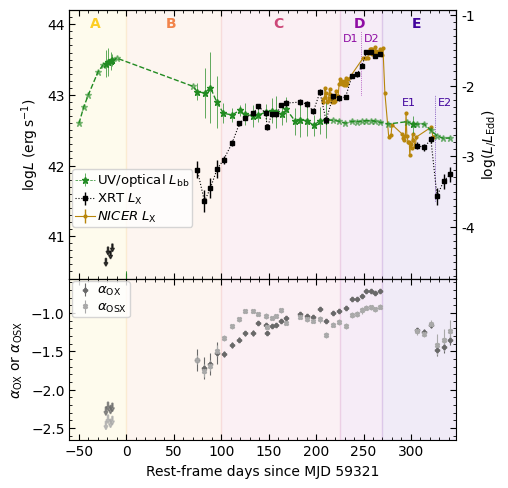

In [9]:
    fig = plt.figure(figsize = (4.8, 4.8))
    gs = fig.add_gridspec(2, 1, 
                          hspace=0.0, wspace = 0, 
                          height_ratios=[2,1.2])
    axs = gs.subplots(sharex=True)
    add_UVoptical(axs)
    add_xray_lc(axs[0], axs[1])
    
    custom_myax1(axs)
    
    plt.tight_layout(rect = (-0.04, -0.02, 1.04, 1.02))